Data source: https://www.kaggle.com/pashupatigupta/emotion-detection-from-text

### Import libraries:

In [1]:
import numpy as np
import pandas as pd
import string, re, os
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score, balanced_accuracy_score, auc, roc_auc_score 
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline 
import matplotlib.pyplot as plt
import seaborn as sns

### Load data:

In [2]:
df = pd.read_csv('tweet_emotions.csv', header=0)
display(df.head())

,tweet_id,sentiment,content
0,1956967341,empty,@tiffanylue i know i was listenin to bad habi...
1,1956967666,sadness,Layin n bed with a headache ughhhh...waitin o...
2,1956967696,sadness,Funeral ceremony...gloomy friday...
3,1956967789,enthusiasm,wants to hang out with friends SOON!
4,1956968416,neutral,@dannycastillo We want to trade with someone w...


### Data preprocessing:

#### Extract X and y:

In [3]:
X = df['content']
y = df['sentiment']
print(X.shape)
print(y.value_counts())

(40000,)
neutral       8638
worry         8459
happiness     5209
sadness       5165
love          3842
surprise      2187
fun           1776
relief        1526
hate          1323
empty          827
enthusiasm     759
boredom        179
anger          110
Name: sentiment, dtype: int64


#### Clean text before using CountVectorizer:

In [4]:
for i in range(len(X)):
    input_str = X[i]
    output_str = re.sub(r'\d+', '', input_str) # Number removal
    punc_trans = {string.punctuation[i]: '' for i in range(len(string.punctuation))}
    output_str = output_str.translate(punc_trans) # Punctuation removal
    output_str = re.sub(r'@\S+ ', '', output_str) # Get rid of tags
    X.loc[i] = output_str

C:\Users\iniad\Miniconda3\envs\ds2021\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [5]:
print(X[:5])

0    i know  i was listenin to bad habit earlier an...
1    Layin n bed with a headache  ughhhh...waitin o...
2                  Funeral ceremony...gloomy friday...
3                 wants to hang out with friends SOON!
4    We want to trade with someone who has Houston ...
Name: content, dtype: object


In [6]:
X.to_csv('ai-07-self_project.csv')

### Conduct analysis

#### Define function to get balanced accuracy with k-folds cross validation:

In [7]:
skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=7)
acc_score = {}
balanced_acc_score = {}

def model_acc(model, X, y, skf, **kwargs):
    model_name = str(model)
    acc_score[model_name] = []
    balanced_acc_score[model_name] = []
    for train, test in skf.split(X, y):
        X_train = X[train]
        X_test = X[test]
            
        vectorizer = CountVectorizer()
        vectorizer.fit(X_train)
        X_train_bow = vectorizer.transform(X_train)
        X_test_bow = vectorizer.transform(X_test)
            
        mod = model.set_params(**kwargs)
        mod.fit(X_train_bow, y[train])
        y_pred = model.predict(X_test_bow)
        y_prob = model.predict_proba(X_test_bow)
        
        acc_score[model_name].append(accuracy_score(y[test], y_pred)) # Accuracy score
        balanced_acc_score[model_name].append(balanced_accuracy_score(y[test], y_pred)) # Balanced accuracy score
        
    acc_score[model_name] = np.mean(acc_score[model_name])
    balanced_acc_score[model_name] = np.mean(balanced_acc_score[model_name])

#### Multinomial Naive Bayes:

In [8]:
model_acc(MultinomialNB(), X, y, skf, alpha=1)

#### Decision Tree Classifier:

In [9]:
model_acc(DecisionTreeClassifier(), X, y, skf, class_weight='balanced')

#### Logistic Regression:

In [10]:
model_acc(LogisticRegression(), X, y, skf, solver='lbfgs', max_iter=1000, multi_class='multinomial')

#### Performance of 3 models:

In [11]:
print(acc_score)
print(balanced_acc_score)

{'MultinomialNB()': 0.317425, 'DecisionTreeClassifier()': 0.22767500000000002, 'LogisticRegression()': 0.337375}
{'MultinomialNB()': 0.14130089245833807, 'DecisionTreeClassifier()': 0.15255691060950818, 'LogisticRegression()': 0.1798168763352339}


Comment: Among 3 models, Logistic Regression seems to work the best, though the accuracy got by all models are all poor.

### Check results of the best model (Logistic Regression):

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=11, stratify=y)

model = LogisticRegression(solver='lbfgs', max_iter=1000, multi_class='multinomial')
vectorizer = CountVectorizer()
vectorizer.fit(X_train)
X_train_bow = vectorizer.transform(X_train)
X_test_bow = vectorizer.transform(X_test)
results = model.fit(X_train_bow, y_train)
y_pred = results.predict(X_test_bow)

#### Result dataframe:

In [14]:
result_df = pd.crosstab(y_pred, y_test)
display(result_df)

sentiment,anger,boredom,empty,enthusiasm,fun,happiness,hate,love,neutral,relief,sadness,surprise,worry
row_0,,,,,,,,,,,,,
anger,0,0,0,0,0,0,0,0,1,0,0,0,0
boredom,0,1,3,0,0,0,2,0,1,0,3,1,1
empty,0,1,2,1,0,2,3,1,6,0,4,1,6
enthusiasm,0,1,0,1,0,8,1,1,2,2,2,2,5
fun,0,1,0,3,27,40,1,17,25,4,18,6,31
happiness,1,2,15,24,118,433,12,184,181,66,49,68,121
hate,3,2,3,4,2,5,66,4,19,4,28,7,42
love,0,1,5,9,31,155,5,339,94,28,49,30,59
neutral,8,9,105,81,154,388,80,206,1206,146,303,196,610


In [15]:
result_df_sum = result_df.sum(axis=0)
display(result_df_sum)

sentiment
anger           27
boredom         45
empty          207
enthusiasm     190
fun            444
happiness     1302
hate           331
love           960
neutral       2159
relief         382
sadness       1291
surprise       547
worry         2115
dtype: int64

#### Plot heatmap:

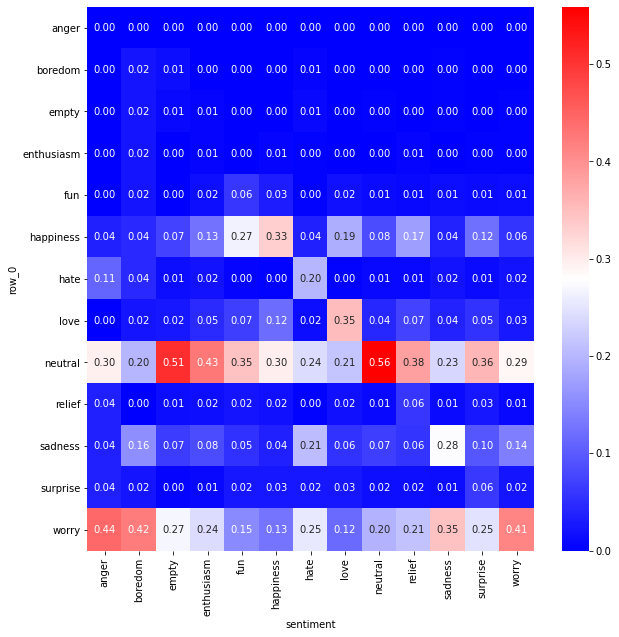

In [16]:
plt.figure(figsize=(10,10)) 
sns.heatmap(result_df/result_df_sum,annot=True,fmt='.2f',cmap='bwr')
plt.show()

### Conclusion:

1. There are some sentiments which are easily messed up with each other: anger and worry, sadness and worry, love and happiness, etc.
2. The model tends to predict the sentiment as 'neutral' the most, which may be led by the overwhelming number of tweets which are labeled as 'neutral' comparing to other sentiments.